In [1]:
#Qiskit Categories
#Terra - Foundation, where we build and test our circuit
#Aer - Simulator, simulation of circuit theoretically
#Ignis - Masks noise, helps understand/mitigate error

#energy relaxation - scenario - leave qbit in energized state, will eventually relax to zero state
#Measurement error mitigation

In [7]:
from qiskit import *

In [8]:
nqubits = 3
circuit = QuantumCircuit(nqubits, nqubits)
circuit.h(0)
circuit.cx(0,1)
circuit.cx(1,2)
circuit.measure([0,1,2], [0,1,2])

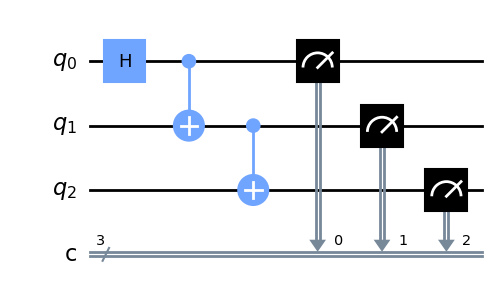

In [9]:
%matplotlib inline
circuit.draw(output='mpl')

In [10]:
#Aer Simulaton
simulator = Aer.get_backend('qasm_simulator')
sim_result = execute(circuit, backend=simulator, shots=1024).result()

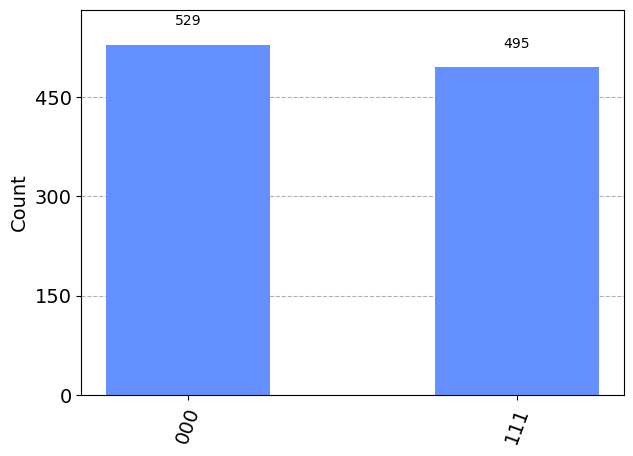

In [11]:
from qiskit.visualization import plot_histogram
plot_histogram(sim_result.get_counts(circuit))

In [12]:
#Terra Real Hardware Execution
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
device = provider.get_backend('ibm_oslo')

In [13]:
job = execute(circuit, backend=device, shots=1024)
print(job.job_id())
from qiskit.tools.monitor import job_monitor
job_monitor(job)

63952bec9a34980a10897981
Job Status: job has successfully run


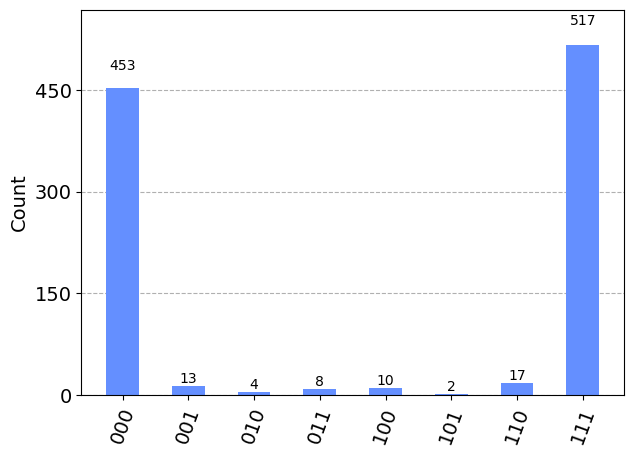

In [14]:
device_result = job.result()
plot_histogram(device_result.get_counts(circuit))

In [15]:
#Ignis Error Mitigation
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)

In [18]:
cal_circuits, state_labels = complete_meas_cal(qr = circuit.qregs[0], circlabel='measerrormitigationcal')

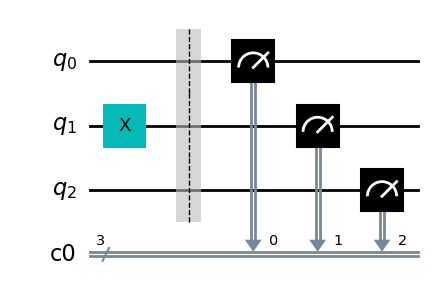

In [19]:
cal_circuits[2].draw(output='mpl')

In [20]:
len(cal_circuits)

8

In [21]:
cal_job = execute(cal_circuits,
                 backend = device,
                  shots = 1024,
                  optimization_level = 0
                 )
print(cal_job.job_id())
job_monitor(cal_job)
cal_results = cal_job.result()

639530d0b1939e68b4b7f10e
Job Status: job has successfully run


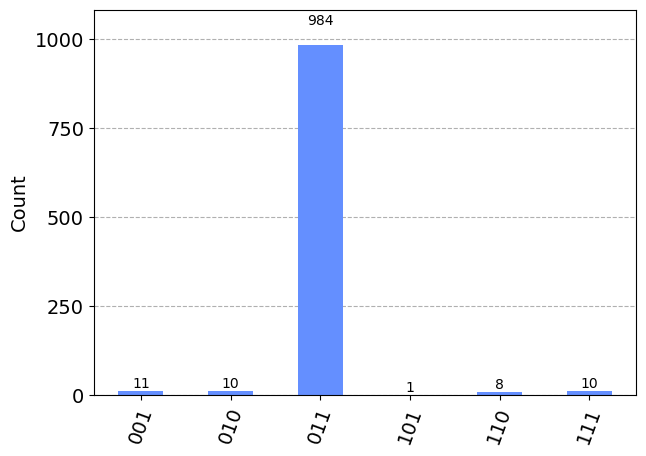

In [22]:
plot_histogram(
cal_results.get_counts(cal_circuits[3])
)

In [23]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels)

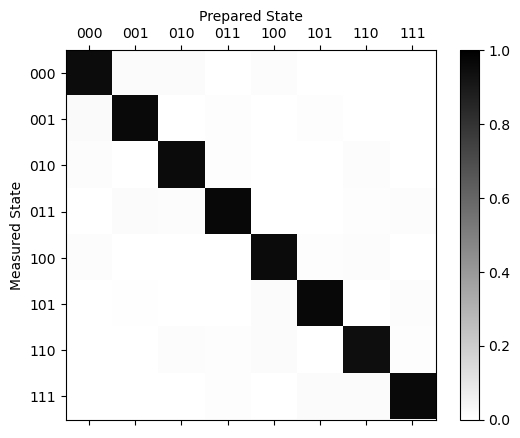

In [24]:
meas_fitter.plot_calibration()

In [25]:
meas_filter = meas_fitter.filter

In [26]:
mitigated_result = meas_filter.apply(device_result)

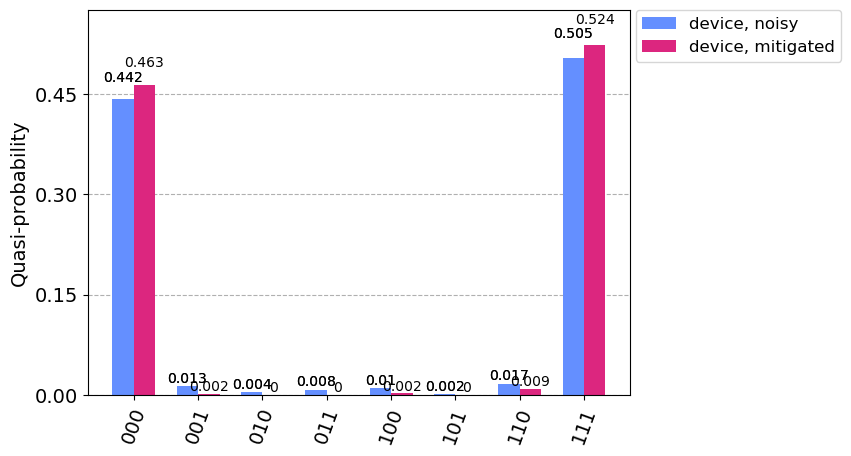

In [28]:
device_counts = device_result.get_counts(circuit)
mitigated_counts = mitigated_result.get_counts(circuit)
plot_histogram([device_counts, mitigated_counts], legend =['device, noisy', 'device, mitigated'])

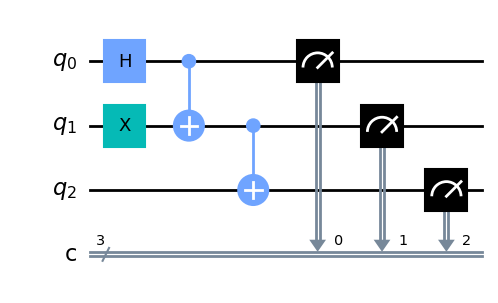

In [29]:
#Another example using a different circuit
circuit2 = QuantumCircuit(3,3)
circuit2.x(1)
circuit2.h(0)
circuit2.cx(0,1)
circuit2.cx(1,2)
circuit2.measure([0,1,2],[0,1,2])
circuit2.draw(output = 'mpl')

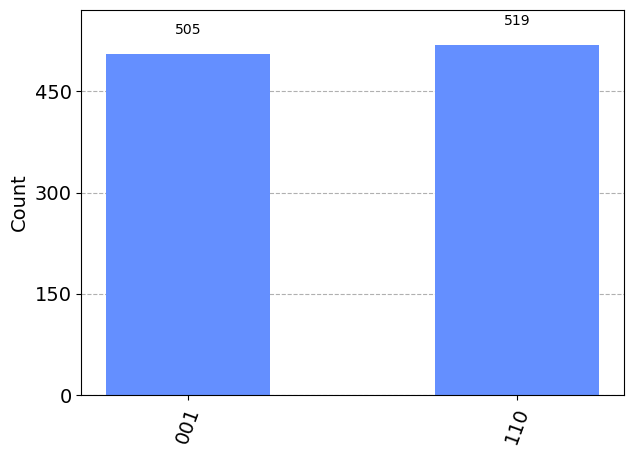

In [30]:
plot_histogram(
    execute(circuit2, backend=simulator, shots = 1024).result().get_counts(circuit2)
)

In [31]:
device_counts_2 = execute(circuit2, backend = device, shots=1024).result().get_counts(circuit2)

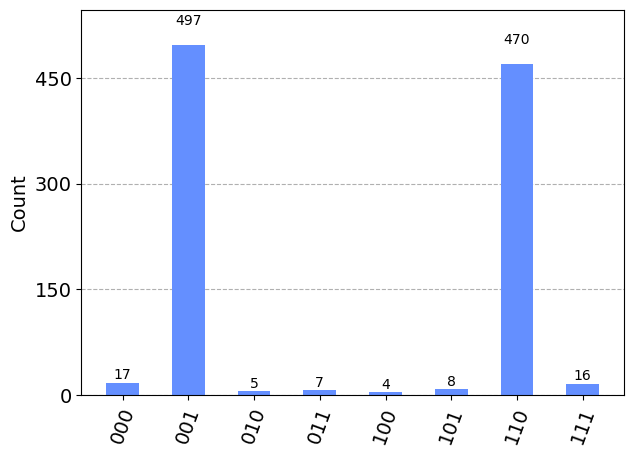

In [32]:
plot_histogram(device_counts_2)

In [33]:
device_mitigated_counts_2 = meas_filter.apply(device_counts_2)

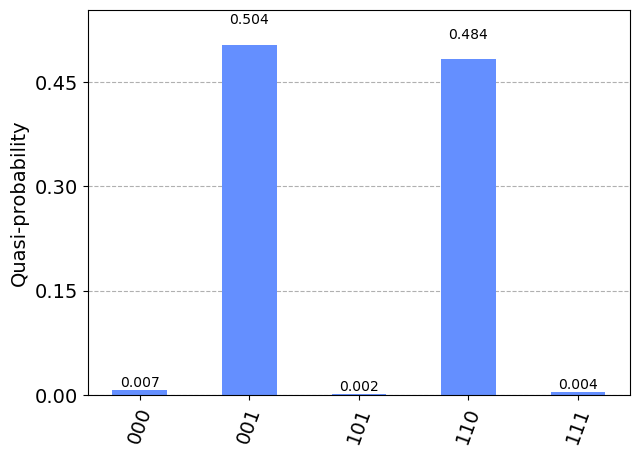

In [34]:
plot_histogram(device_mitigated_counts_2)